# CS440/ECE448 
# MP9: Adversarial Learning and Mechanism Design

The first thing you need to do is to download this file: <a href="template.zip">template.zip</a>.  It has the following content:

* `submitted.py`: Your homework. Edit, and then submit to Gradescope.
* `mp9.ipynb`: This is a <a href="https://anaconda.org/anaconda/jupyter">Jupyter</a> notebook to help you debug.  You can completely ignore it if you want, although you might find that it gives you useful instructions.
* `grade.py`: Once your homework seems to be working, you can test it by typing `python grade.py`, which will run the tests in `tests/tests_visible.py`.
* `tests/test_visible.py`: This file contains about half of the <a href="https://docs.python.org/3/library/unittest.html">unit tests</a> that Gradescope will run in order to grade your homework.  If you can get a perfect score on these tests, then you should also get a perfect score on the additional hidden tests that Gradescope uses.
* `requirements.txt`: This tells you which python packages you need to have installed, in order to run `grade.py`.  You can install all of those packages by typing `pip install -r requirements.txt` or `pip3 install -r requirements.txt`.

This file (`mp9.ipynb`) will walk you through the whole MP, giving you instructions and debugging tips as you go.

### Table of Contents

1. <a href="#sec_nash">Nash Equilibrium</a>
1. <a href="#sec_stability">Stability</a>
1. <a href="#sec_ascent">Adversarial Learning</a>
1. <a href="#sec_paparazzi">No stable equilibrium: The Paparazzi game</a>
1. <a href="#sec_mechanism">Mechanism Design</a>
1. <a href="#sec_grading">Grading</a>


<a name="sec_nash">

## Nash Equilibrium

In the <a href="https://en.wikipedia.org/wiki/Chicken_(game)">game of chicken</a>, each player can gain points by defecting, but only if the other player cooperates.  If both players defect, then they both lose a lot of points.

Suppose that the players are Alice and Bob, and they each have to choose between two possible moves: defect, or cooperate. Alice's reward depends on the actions of both players:

A's reward:      | **B defects** | **B cooperates** |  | B's reward:      | **B defects** | **B cooperates** |
:------------    | :-----------: | :--------------: |--| :-----------     | :-----------: | :--------------: |
**A defects**    | -10           | 2                |  | **A defects**    | -10           | -1               |
**A cooperates** | -1            | 1                |  | **A cooperates** | 2             | 1                |

A Nash equilibrium is a pair of strategies such that each player, knowing the other player's strategy, has no reason to change their own strategy.  The game of chicken has two pure-strategy equilibria.
* (C,D).  If A cooperates, then B prefers to defect.  If B defects, then A prefers to cooperate.
* (D,C).  If A defects, then B prefers to cooperate.  If B cooperates, then A prefers to defect.

It is less well known that the game of chicken also has a mixed-strategy equilibrium.  A "mixed strategy" is a strategy in which the player chooses a move at random.  A mixed strategy is never rational unless the expected reward for cooperating is exactly equal to the expected reward for defecting; in that case one gains nothing by always sticking to the same action, so choosing an action at random is a rational thing to do.  

If A wants B to use a mixed strategy, then she needs to choose her own strategy in order to make B's average reward independent of his action.  For the reward matrices shown above, she can do so, if she chooses, by choosing her own action at random: By cooperating with probability $\frac{9}{10}$, and defecting with probability $\frac{1}{10}$.  In this case, B's rewards are independent of his action, so it is rational for him to behave at random:

$$E[r_B|B=d] = P(A=d)r_B(d,d)+P(A=c)r_B(c,d)=\frac{1}{10}(-10)+\frac{9}{10}(2)=\frac{8}{10}$$
$$E[r_B|B=c] = P(A=d)r_B(d,c)+P(A=c)r_B(c,c)=\frac{1}{10}(-1)+\frac{9}{10}(1)=\frac{8}{10}$$

The rest of this MP will use equations like the ones above quite frequently, so it's useful to create some matrix notation.  Let's define $\mathbf{p}_A=[P(A=d),P(A=c)]^T$ to be A's mixed strategy vector, and define $\mathbf{R}_B$ to be B's reward matrix.  The equations above can be written as

$$\mathbf{p}_A^T\mathbf{R}_B =\left[\frac{1}{10},\frac{9}{10}\right]
\left[\begin{array}{cc}-10&-1\\2&1\end{array}\right]=\left[\begin{array}{c}\frac{8}{10}\\\frac{8}{10}\end{array}\right]$$

Of course, it is only rational for A to use a mixed strategy if her reward is also independent of her action.  If B wants A to use a mixed strategy, then he needs to choose his own strateg in order to make A's reward independent of her action.  For the reward matrices shown above, this can be done if B also uses a mixed strategy vector of $\mathbf{p}_B=\left[\frac{1}{10},\frac{9}{10}\right]^T$, thus:

$$\mathbf{R}_A\mathbf{p}_B =
\left[\begin{array}{cc}-10&2\\-1&1\end{array}\right]\left[\begin{array}{c}\frac{1}{10}\\\frac{9}{10}\end{array}\right]=
\left[\frac{8}{10},\frac{8}{10}\right]
$$


In [ ]:
import numpy as np

reward = np.array([[[-10,2],[-1,1]],[[-10,-1],[2,1]]])
print('The reward matrices are:')
print(reward)

pA = np.array([0.1,0.9])
print("\nA's mixed strategy vector is:")
print(pA)

print("\nThe expected rewards for B, as a function of his actions, are:")
print(pA@reward[1,:,:])

pB = np.array([0.1,0.9])
print("\nB's mixed strategy vector is:")
print(pB)

print("\nThe expected rewards for A, as a function of her actions, are:")
print(reward[0,:,:]@pB)

The reward matrices are:
[[[-10   2]
  [ -1   1]]

 [[-10  -1]
  [  2   1]]]

A's mixed strategy vector is:
[0.1 0.9]

The expected rewards for B, as a function of his actions, are:
[0.8 0.8]

B's mixed strategy vector is:
[0.1 0.9]

The expected rewards for A, as a function of her actions, are:
[0.8 0.8]


If both players use these mixed strategies, then their expected rewards are

$$E[r_A] = \mathbf{p}_A^T\mathbf{R}_A\mathbf{p}_B = \frac{8}{10}$$
$$E[r_B] = \mathbf{p}_A^T\mathbf{R}_B\mathbf{p}_B = \frac{8}{10}$$


In [ ]:
print("A's expected reward is:")
print(pA@reward[0,:,:]@pB)

print("\n")
print("B's expected reward is:")
print(pA@reward[1,:,:]@pB)

A's expected reward is:
0.8


B's expected reward is:
0.8


<a name="sec_stability">

## Stability

Sadly, the chicken game's mixed equilibrium is unstable.

An equilibrium is stable if small deviations are corrected.  For example, suppose that Alice modified her probabilities slightly, to $\mathbf{p}_A=[0.11,0.89]^T$.  If the reward structure of the game encourages her to shift back again toward $\mathbf{p}_A=[0.1,0.9]^T$, then the equilibrium is stable.  On the other hand, if the reward structure encourages her to shift even farther away, then the equilibrium is unstable.

Stability can be defined in terms of the gradients of the expected rewards with respect to the strategy logits.  A "logit'' is the log ratio of a probability over its complement:

$$z_A = \log\left(\frac{P(A=c)}{1-P(A=c)}\right),~~~P(A=c)=\frac{1}{1+e^{-z_A}}$$
$$z_B = \log\left(\frac{P(B=c)}{1-P(B=c)}\right),~~~P(B=c)=\frac{1}{1+e^{-z_B}}$$

A mixed Nash equilibrium can be defined as a pair of strategies at which the derivative of each player's expected reward with respect to the same player's strategy is zero:

$$\frac{\partial E[r_A]}{\partial z_A}=\frac{\partial \mathbf{p}_A^T}{\partial z_A}\mathbf{R}_A\mathbf{p}_B=0$$
$$\frac{\partial E[r_B]}{\partial z_B}=\mathbf{p}_A\mathbf{R}_B\frac{\partial \mathbf{p}_B}{\partial z_B}=0$$

In order to verify the mixed Nash equilibrium of the game of chicken, please write the homework function `submitted.utility_gradients.`. Here is its docstring:

In [ ]:
import submitted, importlib

help(submitted.utility_gradients)

Help on function utility_gradients in module submitted:

utility_gradients(logit, reward)
    Calculate partial derivatives of expected rewards with respect to logits.

    @param:
    logit - player i plays move 1 with probability 1/(1+exp(-logit[i]))
    reward - reward[i,a,b] is reward to player i if player 0 plays a, and player 1 plays b

    @return:
    gradients - gradients[i]= dE[reward[i,:,:]]/dlogit[i]
    utilities - utilities[i] = E[reward[i,:,:]]
      where the expectation is computed over the distribution of possible moves by both players.



Once you have written `submitted.utility_gradients`, you can check to verify the mixed equilibrium of the game of chicken.  The logits for this equilibrium are:

$$z_A = \log\left(\frac{P(A=c)}{1-P(A=c)}\right)=\log\left(\frac{9/10}{1/10}\right)=\log(9)$$
$$z_B = \log\left(\frac{P(B=c)}{1-P(B=c)}\right)=\log\left(\frac{9/10}{1/10}\right)=\log(9)$$

In order for $(z_A,z_B)=(\log(9),\log(9))$ to be a Nash equilibrium, the expected rewards of each player must be unchanged by small changes in strategy, i.e.:

In [ ]:
importlib.reload(submitted)

logit = np.log([9,9])
print("The logits of both players are:")
print(logit)
print("\n")

gradients, utilities = submitted.utility_gradients(logit, reward)

print("This is a Nash equilibrium, because the gradients of the expected rewards are both zero:")
print(gradients)
print("\n")

print("As we previously calculated, the expected rewards for each player are:")
print(utilities)

The logits of both players are:
[2.19722458 2.19722458]


This is a Nash equilibrium, because the gradients of the expected rewards are both zero:
[ 0.00000000e+00 -1.38777878e-17]


As we previously calculated, the expected rewards for each player are:
[0.8 0.8]


Unfortunately, this is an unstable equilibrium.  
* If either player increases their logit, then the gradient of the other player becomes negative, meaning that the other player can improve their reward by decreasing their logit.
* If either player decreases their logit, then the gradient of the other player becomes positive, meaning that the other player can improve their reward by increasing their logit.

In [ ]:
gradients, utilities = submitted.utility_gradients(logit+np.array([0,0.1]), reward)
print("If Bob increases his logit slightly, the gradients become:")
print(gradients)
print("\n")

gradients, utilities = submitted.utility_gradients(logit+np.array([0,-0.1]), reward)
print("If Bob decreases his logit slightly, the gradients become:")
print(gradients)
print("\n")

gradients, utilities = submitted.utility_gradients(logit+np.array([0.1,0]), reward)
print("If Alice increases her logit slightly, the gradients become:")
print(gradients)
print("\n")

gradients, utilities = submitted.utility_gradients(logit+np.array([-0.1,0]), reward)
print("If Alice decreases her logit slightly, the gradients become:")
print(gradients)
print("\n")


If Bob increases his logit slightly, the gradients become:
[-7.78222682e-03 -1.38777878e-17]


If Bob decreases his logit slightly, the gradients become:
[ 8.43018335e-03 -1.38777878e-17]


If Alice increases her logit slightly, the gradients become:
[ 0.         -0.00778223]


If Alice decreases her logit slightly, the gradients become:
[0.         0.00843018]




<a name="sec_ascent">

## Adversarial Learning

What happens if both players follow their gradient, in an attempt to increase their rewards?  Let's find out.

In [ ]:
importlib.reload(submitted)
help(submitted.strategy_gradient_ascent)

Help on function strategy_gradient_ascent in module submitted:

strategy_gradient_ascent(logit, reward, nsteps, learningrate)
    nsteps of a 2-player, 2-action episodic game, strategies learned
    using simultaneous gradient ascent.

    @param:
    logit - intial logits for the two players
    reward - reward[i,a,b] is reward to player i if player 0 plays a, and player 1 plays b
    nsteps - number of steps of ascent to perform
    learningrate - learning rate

    @return:
    path - path[t,i] is the logit of the i'th player's strategy after t steps of
      simultaneous gradient ascent (path[0,:]==logit).
    utilities (nsteps,2) - utilities[t,i] is the expected reward to player i on step t,
      where expectation is over the distribution of moves given by logits[t,:]



Now let's start at the Nash equilibrium, and iterate for 1000 steps.  

In [ ]:
importlib.reload(submitted)

logit = np.array([np.log(9), np.log(9)])
path, utilities = submitted.strategy_gradient_ascent(logit, reward, 1000, 0.1)

Text(0.5, 0, 'Iteration number')

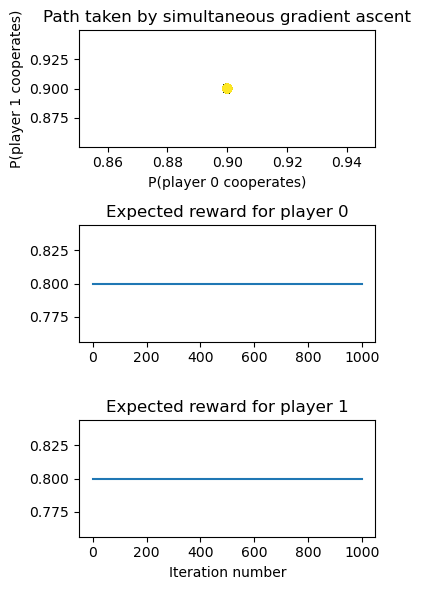

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,1, figsize=(4,6),layout='tight')
ax[0].scatter(1/(1+np.exp(-path[:,0])), 1/(1+np.exp(-path[:,1])), c=np.arange(1000))
ax[0].set_xlabel('P(player 0 cooperates)')
ax[0].set_ylabel('P(player 1 cooperates)')
ax[0].set_title('Path taken by simultaneous gradient ascent')
ax[1].plot(utilities[:,0])
ax[1].set_title('Expected reward for player 0')
ax[2].plot(utilities[:,1])
ax[2].set_title('Expected reward for player 1')
ax[2].set_xlabel('Iteration number')

As you can see, the Nash equilibrium really is an equilibrium -- if players start out with that strategy, then neither of them can improve their expected reward by making any small change!  However, it's an unstable equilibrium.  If one of the players starts just a little bit away from that equilibrium, then the strategies diverge.

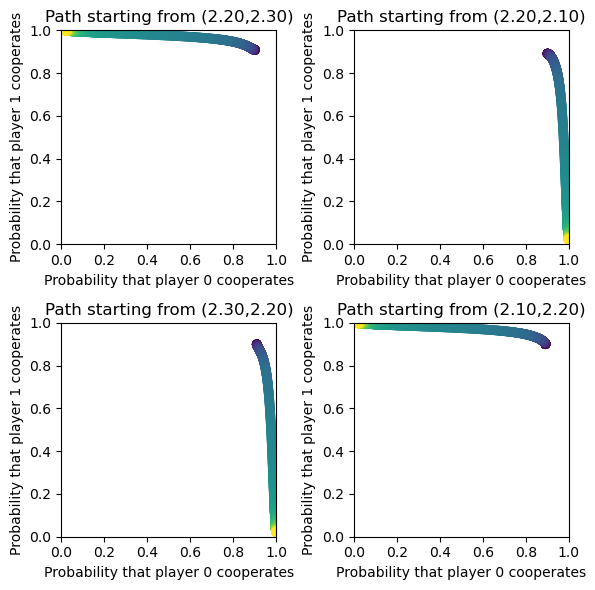

In [ ]:
starting_points = np.tile(logit, (2,2,1)) + np.array([[[0,0.1],[0,-0.1]],[[0.1,0],[-0.1,0]]])

fig, axs = plt.subplots(2,2, figsize=(6,6), layout='tight')
for i in range(2):
    for j in range(2):
        path, utilities = submitted.strategy_gradient_ascent(starting_points[i,j,:], reward, 1000, 0.1)
        axs[i,j].scatter(1/(1+np.exp(-path[:,0])), 1/(1+np.exp(-path[:,1])), c=np.arange(1000))
        axs[i,j].set_xlabel('Probability that player 0 cooperates')
        axs[i,j].set_ylabel('Probability that player 1 cooperates')
        axs[i,j].set_title("Path starting from (%.2f,%.2f)"%(starting_points[i,j,0],starting_points[i,j,1]))
        axs[i,j].set_xlim(0,1)
        axs[i,j].set_ylim(0,1)


* If the starting strategy has A cooperating slightly less than $\frac{9}{10}$ of the time, or B cooperating slightly more than $\frac{9}{10}$ of the time, then each player, gradually increasing their own expected reward, eventually converges to a strategy in which A always defects, and B always cooperates.
* If the starting strategy has A cooperating slightly more than $\frac{9}{10}$ of the time, or B cooperating slightly less than $\frac{9}{10}$ of the time, then each player, gradually increasing their own expected reward, eventually converges to a strategy in which A always cooperates, and B always defects.

In this sense, the mixed equilibrium of the game of chicken is unstable, and the two fixed-strategy equilibria are both stable.

<a name="sec_paparazzi">

## No stable equilibrium: The Paparazzi game

Every two-player, two-move game has at least one Nash equilibrium, but some games have no stable Nash equilibrium.

For example, consider the "Paparazzi game," in which A wins more if her move is the opposite of B's move, whereas B wins more if his move is the same as A:

In [ ]:
reward = np.array([[[-1,1],[1,-1]],[[1,-1],[-1,1]]])
print(reward)

[[[-1  1]
  [ 1 -1]]

 [[ 1 -1]
  [-1  1]]]


This game has just one Nash equilibrium: if both players cooperate with probability 50%, then they both win, on average, 0 points per game.

Text(0.5, 1.0, 'Simultaneous gradient ascent for the Paparazzi game, starting from equlibrium')

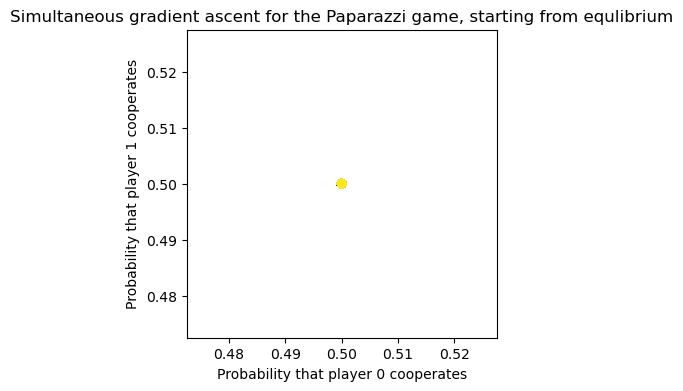

In [ ]:
importlib.reload(submitted)

path, utilities = submitted.strategy_gradient_ascent([0,0], reward, 1000, 0.1)

fig, ax = plt.subplots(1, figsize=(4,4))
ax.scatter(1/(1+np.exp(-path[:,0])), 1/(1+np.exp(-path[:,1])), c=np.arange(1000))
ax.set_xlabel('Probability that player 0 cooperates')
ax.set_ylabel('Probability that player 1 cooperates')
ax.set_title('Simultaneous gradient ascent for the Paparazzi game, starting from equlibrium')

However, if we start from any position other than the equilibrium, then gradient descent fails to converge.

Text(0, 0.5, 'Probability that player 1 cooperates')

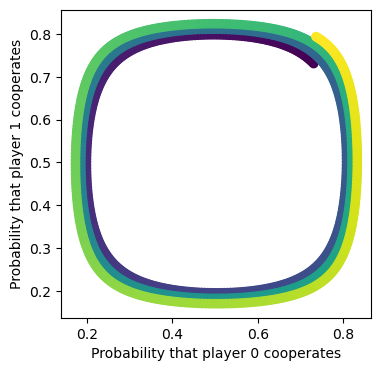

In [ ]:
importlib.reload(submitted)

path, utilities = submitted.strategy_gradient_ascent([1,1], reward, 1000, 0.1)

fig, ax = plt.subplots(1, figsize=(4,4))
ax.scatter(1/(1+np.exp(-path[:,0])),1/(1+np.exp(-path[:,1])), c=np.arange(1000))
ax.set_xlabel('Probability that player 0 cooperates')
ax.set_ylabel('Probability that player 1 cooperates')

As you can see, gradient descent does not converge to the Nash equilibrium; instead, the players orbit around the Nash equilibrium:

* When player 1 is usually defecting, then player 0 increases their cooperation probability
* When player 0 is usually cooperating, then player 1 increases their cooperation probability
* When player 1 is usually cooperating, then player 0 decreases their cooperation probability
* When player 0 is usually defecting, then player 1 decreases their cooperation probability

<a name="sec_mechanism">

## Mechanism Design

Mechanism design is the process of designing the rewards of a game in order to encourage the players to act in a particular way.

For example, suppose that we want Alice to choose between defecting and cooperating according to probability vector $\mathbf{p}_A$, and we want Bob to choose according to probability vector $\mathbf{p}_B$.  Remember that a mixed strategy is rational for Alice only if her expected reward is independent of her action, i.e., the two elements of the vector $\mathbf{R}_A\mathbf{p}_B$ are the same, i.e., only if $[-1,1]\mathbf{R}_A\mathbf{p}_B=0$.  Likewise, a mixed strategy is rational for Bob only if his expected reward is independent of his action, i.e., only if $\mathbf{p}_A^T\mathbf{R}_B\left[\begin{array}{c}-1\\1\end{array}\right]=0$.

Let's use the term "strategy mismatch" to mean the degree to which Alice's two actions give different rewards, $[-1,1]\mathbf{R}_A\mathbf{p}_B$.  Likewise, Bob's strategy mismatch is $\mathbf{p}_A^T\mathbf{R}_B\left[\begin{array}{c}-1\\1\end{array}\right]$.  We can create a game in which $(\mathbf{p}_A,\mathbf{p}_B)$ is a Nash equilibrium if we can set the mean-squared-strategy-mismatch to zero, i.e., set $\mathcal{L}=0$ where

$$\mathcal{L}=\frac{1}{2}\left([-1,1]\mathbf{R}_A\mathbf{p}_B\right)^2+\frac{1}{2}\left(\mathbf{p}_A^T\mathbf{R}_B\left[\begin{array}{c}-1\\1\end{array}\right]\right)^2$$

In [ ]:
importlib.reload(submitted)

help(submitted.mechanism_gradient)

Help on function mechanism_gradient in module submitted:

mechanism_gradient(logit, reward)
    Calculate partial derivative of mechanism loss with respect to rewards.

    @param:
    logit - The goal is to make this pair of strategies a Nash equlibrium:
        player i plays move 1 with probability 1/(1+exp(-logit[i])), else move 0
    reward - reward[i,a,b] is reward to player i if player 0 plays a, and player 1 plays b

    @return:
    gradient - gradient[i,a,b]= derivative of loss w.r.t. reward[i,a,b]
    loss - half of the mean-squared strategy mismatch.
        Mean = average across both players.
        Strategy mismatch = difference between the expected reward that
        the player earns by cooperating (move 1) minus the expected reward that
        they earn by defecting (move 0).



For the paparazzi game, the vectors $\mathbf{p}_A=\left[\begin{array}{c}1/2\\1/2\end{array}\right],\mathbf{p}_B=\left[\begin{array}{c}1/2\\1/2\end{array}\right]$, corresponding to the logits $(z_A,z_B)=(0,0)$, are a Nash equilibrium, so if we evaluate the paparazzi game with these strategies, we should find that the loss is zero and the gradient is zero.

In [ ]:
importlib.reload(submitted)

# paparazzi game
reward = np.array([[[-1,1],[1,-1]],[[1,-1],[-1,1]]]) # paparazzi
gradient, loss = submitted.mechanism_gradient(np.zeros(2), reward) # paparazzi game

print("At equilibrium, the gradient of mean-squared strategy mismatch w.r.t. reward matrices is:")
print(gradient)
print("\n")

print("... and the mean-squared strategy mismatch is:")
print(loss)

At equilibrium, the gradient of mean-squared strategy mismatch w.r.t. reward matrices is:
[[[-0. -0.]
  [ 0.  0.]]

 [[-0.  0.]
  [-0.  0.]]]


... and the mean-squared strategy mismatch is:
[0.]


On the other hand, suppose we want to modify the paparazzi game so that the strategies $\mathbf{p}_A=\left[\begin{array}{c}9/20\\11/20\end{array}\right],\mathbf{p}_B=\left[\begin{array}{c}11/20\\9/20\end{array}\right]$ are a Nash equilibrium.  These strategies  correspond to the logits $(z_A,z_B)=(\log(2),\log(2))$.  If we start from the original reward matrix of the paparazzi game, we should find that there is a nonzero loss, and a nonzero gradient:

In [ ]:
importlib.reload(submitted)
gradient, loss = submitted.mechanism_gradient(np.log([11/9,9/11]), reward)

print("If we want to adjust the paparazzi game to make [log(11/9),log(9/11)] an equilibrium, the gradient is:")
print(gradient)
print("\n")

print("... and the mean-squared strategy mismatch is:")
print(loss)

If we want to adjust the paparazzi game to make [log(11/9),log(9/11)] an equilibrium, the gradient is:
[[[-0.11 -0.09]
  [ 0.11  0.09]]

 [[-0.09  0.09]
  [-0.11  0.11]]]


... and the mean-squared strategy mismatch is:
[0.04]


Let's write a function that will start with an initial setting of the rewards, and adjust the rewards until the desired strategies become a Nash equilibrium.

In [ ]:
importlib.reload(submitted)
help(submitted.mechanism_gradient_descent)

Help on function mechanism_gradient_descent in module submitted:

mechanism_gradient_descent(logit, reward, nsteps, learningrate)
    nsteps of gradient descent on the mean-squared strategy mismatch
    using simultaneous gradient ascent.

    @param:
    logit - The goal is to make this pair of strategies a Nash equlibrium:
        player i plays move 1 with probability 1/(1+exp(-logit[i])), else move 0.
    reward - Initial setting of the rewards.
        reward[i,a,b] is reward to player i if player 0 plays a, and player 1 plays b
    nsteps - number of steps of gradient descent to perform
    learningrate - learning rate

    @return:
    path - path[t,i,a,b] is the reward to player i of the moves (a,b) after t steps
      of gradient descent (path[0,:,:,:] = initial reward).
    loss - loss[t] is half of the mean-squared strategy mismatch at iteration [t].
        Mean = average across both players.
        Strategy mismatch = difference between the expected reward that
        th

In [ ]:
importlib.reload(submitted)

path, loss = submitted.mechanism_gradient_descent(np.log([11/9,9/11]), reward, 1000, 0.1)

print("The following reward matrices have a Nash equilibrium where Alice cooperates w/prob 11/20, Bob w/prob 9/20:")
print(path[-1,:,:,:])
print("\n")
print("... with a mean-squared strategy mismatch of:",loss[-1],"\n")

print("Just to make sure, let's calculate the utility gradients:")
g, u = submitted.utility_gradients(np.log([11/9,9/11]), path[-1,:,:,:])
print("At the new equilibrium, the gradients are",g)
print("... and the utilities are",u)

The following reward matrices have a Nash equilibrium where Alice cooperates w/prob 11/20, Bob w/prob 9/20:
[[[-0.89108911  1.08910891]
  [ 0.89108911 -1.08910891]]

 [[ 1.08910891 -1.08910891]
  [-0.89108911  0.89108911]]]


... with a mean-squared strategy mismatch of: 9.98402083170343e-31 

Just to make sure, let's calculate the utility gradients:
At the new equilibrium, the gradients are [2.49800181e-16 2.47302179e-16]
... and the utilities are [ 2.08166817e-17 -4.99600361e-17]


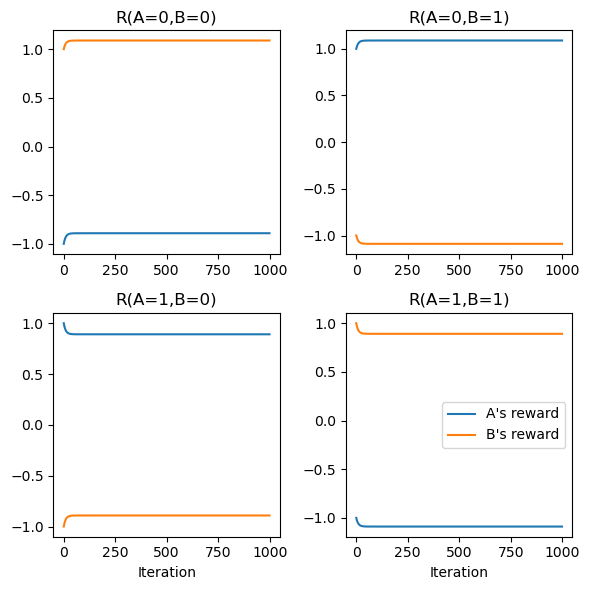

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(6,6), layout='tight')
for i in range(2):
    for j in range(2):
        r0, r1 = axs[i,j].plot(path[:,:,i,j])
        axs[i,j].set_title("R(A=%d,B=%d)"%(i,j))
axs[1,0].set_xlabel('Iteration')
axs[1,1].set_xlabel('Iteration')
plt.legend((r0,r1),("A's reward","B's reward"))

We see that gradient descent on the mean-squared strategy mismatch results in a new reward matrix that's pretty similar to the old one (at least in this case, where the target Nash equilibrium is pretty close to the original equilibrium).  The rewards have been adjusted slightly, though, so that Alice gets slightly more reward if Bob chooses move 1 (which he now does less often), whereas Bob gets slightly more reward if Alice chooses move 0 (which she now does less often).

Just to be sure everything works, you might want to try those things with the game of chicken as well:

At equilibrium, the gradient of mean-squared strategy mismatch w.r.t. reward matrices is:
[[[ 1.11022302e-17  9.99200722e-17]
  [-1.11022302e-17 -9.99200722e-17]]

 [[ 1.11022302e-17 -1.11022302e-17]
  [ 9.99200722e-17 -9.99200722e-17]]]


... and the mean-squared strategy mismatch is:
[1.23259516e-32]


If we want to adjust the paparazzi game to make [log(8),log(8)] an equilibrium, the gradient is:
[[[-0.01234568 -0.09876543]
  [ 0.01234568  0.09876543]]

 [[-0.01234568  0.01234568]
  [-0.09876543  0.09876543]]]


... and the mean-squared strategy mismatch is:
[0.01234568]


The following reward matrices have a Nash equilibrium where each player cooperates with probability 8/9:
[[[-9.99230769  2.06153846]
  [-1.00769231  0.93846154]]

 [[-9.99230769 -1.00769231]
  [ 2.06153846  0.93846154]]]


...with a mean-squared strategy mismatch of
1.9721522630525295e-31


Just to make sure, let's calculate the utility gradients:
At the new equilibrium, the gradients are [2.77555756e-17 5.5511151

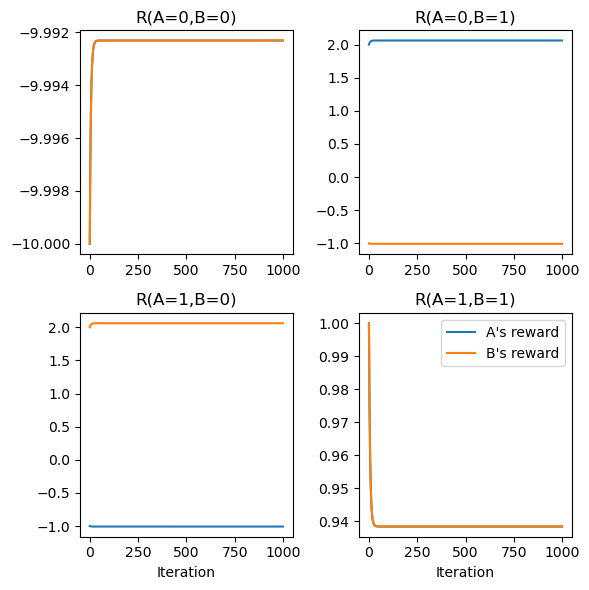

In [ ]:
# game of chicken
reward = np.array([[[-10,2],[-1,1]],[[-10,-1],[2,1]]]) ### delete this to use paparazzi game
gradient, loss = submitted.mechanism_gradient(np.log([9,9]), reward) # chicken game

print("At equilibrium, the gradient of mean-squared strategy mismatch w.r.t. reward matrices is:")
print(gradient)
print("\n")

print("... and the mean-squared strategy mismatch is:")
print(loss)
print("\n")

gradient, loss = submitted.mechanism_gradient(np.log([8,8]), reward)

print("If we want to adjust the paparazzi game to make [log(8),log(8)] an equilibrium, the gradient is:")
print(gradient)
print("\n")

print("... and the mean-squared strategy mismatch is:")
print(loss)
print("\n")

path, loss = submitted.mechanism_gradient_descent(np.log([8,8]), reward, 1000, 0.1)

print("The following reward matrices have a Nash equilibrium where each player cooperates with probability 8/9:")
print(path[-1,:,:,:])
print("\n")

print("...with a mean-squared strategy mismatch of")
print(loss[-1])
print("\n")

print("Just to make sure, let's calculate the utility gradients:")
g, u = submitted.utility_gradients(np.log([8,8]), path[-1,:,:,:])
print("At the new equilibrium, the gradients are",g)
print("... and the utilities are",u)


fig, axs = plt.subplots(2,2, figsize=(6,6), layout='tight')
for i in range(2):
    for j in range(2):
        r0, r1 = axs[i,j].plot(path[:,:,i,j])
        axs[i,j].set_title("R(A=%d,B=%d)"%(i,j))
axs[1,0].set_xlabel('Iteration')
axs[1,1].set_xlabel('Iteration')
plt.legend((r0,r1),("A's reward","B's reward"))

Again, for a target equlibrium close to the original equilibrium, we find that the reward matrix doesn't need to be changed very much.

<a name="sec_grading">

## Grading

You can test your code on your own machine, using the visible test cases, by running `python grade.py`.

When that works, submit your `submitted.py` to the autograder.  The autograder will run the visible test cases, and also some hidden test cases, in order to generate your final score for this MP.